# Training

## 목표 모델
- 입력: 곡의 bpm, 맵의 njs, 3x4 그리드의 위치별 초당 노트 개수 12개 총 14차원으로 이루어진 맵 데이터(nps의 세분화)
- 출력: Easy, Normal, Hard, Expert, Expert+에 대응하는 난이도 1이상 5이하의 정수 중 하나의 값.
- 모델: Classification 모델

## CUDA 로드 및 GPU 상태 확인

In [61]:
import torch
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    print("CUDA is available! Success!")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Check installation.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!nvidia-smi

CUDA is available! Success!
Device Name: NVIDIA GeForce RTX 5070
Wed Dec  3 23:17:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   33C    P5             15W /  250W |    1214MiB /  12227MiB |      4%      Default |
|                                         |                        |       

## 데이터 로드 및 전처리

In [62]:
data_path = './data/data.json'

with open(data_path, "r", encoding="utf-8") as f:
    loaded_list = json.load(f)
    print(type(loaded_list))

df_data = pd.DataFrame(loaded_list)

<class 'list'>


In [63]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ver       988 non-null    object 
 1   songName  988 non-null    object 
 2   bpm       988 non-null    float64
 3   diff      988 non-null    int64  
 4   fileName  988 non-null    object 
 5   njs       988 non-null    float64
 6   songNo    988 non-null    int64  
 7   infoPath  988 non-null    object 
 8   lvlNo     988 non-null    int64  
 9   notes     988 non-null    object 
 10  duration  988 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 85.0+ KB


In [64]:
columns_to_keep = ['bpm', 'diff', 'njs', 'notes', 'duration']

df_selected = df_data[columns_to_keep]

In [65]:
X = df_selected.drop('diff', axis=1)
Y = df_selected['diff'] - 1

# (train + valid) 데이터와 test 데이터를 9:1 비율로 분리
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X, Y,
    test_size = 0.1,
    random_state = 42,
    stratify = Y
)

# train과 valid 데이터를 8:1 비율로 분리
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train_val, Y_train_val,
    test_size = (0.1 / 0.9),
    random_state = 42,
    stratify = Y_train_val
)

# 최종적으로 train:valid:test = 8:1:1 비율이며 각 데이터안에서 난이도는 동일한 비율로 분포함.

In [66]:
print(len(X), len(Y))

988 988


In [67]:
# 노트 데이터 정규화
def calculate_nps_features(df_input: pd.DataFrame) -> pd.DataFrame:
    def process_notes_to_nps(row):

        notes_list = row['notes']
        duration = row['duration']
        
        grid_counts = [[0 for _ in range(3)] for _ in range(4)]
        
        # 1. 노트 카운트
        for note in notes_list:
            if note['x'] >= 0 and note['x'] <= 3 and note['y'] >= 0 and note['y'] <= 2:
                x = note['x']
                y = note['y']
                grid_counts[x][y] += 1
        
        # 2. NPS 계산 및 결과 딕셔너리 생성
        nps_vector = {}
        
        for x in range(4):
            for y in range(3):
                col_name = f'NPS_{x}_{y}'
                count = grid_counts[x][y]
                nps_vector[col_name] = count / duration
                    
        # 3. Pandas Series 형태로 반환
        return pd.Series(nps_vector)
    
    # DataFrame에 함수 적용 및 결과 합치기
    
    # apply(axis=1)을 사용하여 각 행(맵)별로 NPS 벡터 계산
    # 이 결과는 12개의 NPS 컬럼을 가진 새로운 DataFrame이 됩니다.
    nps_df = df_input.apply(process_notes_to_nps, axis=1).reset_index(drop=True)
    
    # 전역 정보 컬럼 선택
    global_features = df_input[['bpm', 'njs']].reset_index(drop=True)

    # 전역 정보 컬럼 minmax 정규화
    global_features['bpm'] = (global_features['bpm'] - global_features['bpm'].min()) / (global_features['bpm'].max() - global_features['bpm'].min())
    global_features['njs'] = (global_features['njs'] - global_features['njs'].min()) / (global_features['njs'].max() - global_features['njs'].min())
    
    # NPS 벡터와 전역 정보를 수평으로 병합 (총 12 + 2 = 14차원)
    result_df = pd.concat([global_features, nps_df], axis=1)

    return result_df

print(len(X_train))
X_train = calculate_nps_features(X_train)
X_valid = calculate_nps_features(X_valid)
X_test = calculate_nps_features(X_test)
print(len(X_train))

790
790


In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bpm      790 non-null    float64
 1   njs      790 non-null    float64
 2   NPS_0_0  790 non-null    float64
 3   NPS_0_1  790 non-null    float64
 4   NPS_0_2  790 non-null    float64
 5   NPS_1_0  790 non-null    float64
 6   NPS_1_1  790 non-null    float64
 7   NPS_1_2  790 non-null    float64
 8   NPS_2_0  790 non-null    float64
 9   NPS_2_1  790 non-null    float64
 10  NPS_2_2  790 non-null    float64
 11  NPS_3_0  790 non-null    float64
 12  NPS_3_1  790 non-null    float64
 13  NPS_3_2  790 non-null    float64
dtypes: float64(14)
memory usage: 86.5 KB


## 모델 정의

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class BeatSaberMLP(nn.Module):
    def __init__(self):
        super(BeatSaberMLP, self).__init__()
        # 14 -> 32 -> ReLU
        self.layer1 = nn.Sequential(
            nn.Linear(14, 32),
            nn.ReLU()
        )
        # 32 -> 16 -> ReLU
        self.layer2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU()
        )
        # 16 -> 5 (Softmax는 Loss 함수에 포함됨)
        self.layer3 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

## 데이터 변환 및 GPU이동

In [70]:
def prepare_data(X_df, y_df, device):
    # 1. X 데이터: DataFrame -> Numpy -> FloatTensor -> GPU로 이동
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_df.values, dtype=torch.long).to(device)
    
    return X_tensor, y_tensor

X_train_gpu, y_train_gpu = prepare_data(X_train, Y_train, device)
X_valid_gpu, y_valid_gpu = prepare_data(X_valid, Y_valid, device)
X_test_gpu, y_test_gpu  = prepare_data(X_test, Y_test, device)

In [71]:
print(len(X_train_gpu), len(X_train), len(Y_train))

790 790 790


## 모델 생성 및 GPU로 이동

In [72]:
model = BeatSaberMLP().to(device)

## 학습 설정

In [73]:
criterion = nn.CrossEntropyLoss() # 내부적으로 Softmax 포함
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 학습 루프

In [74]:
EPOCHS = 500

history = {
    'epochs': [],
    'train_loss': [],
    'val_acc': []
}

print("\n--- 학습 시작 ---")
for epoch in range(EPOCHS):
    model.train() # 학습 모드
    
    # 1. Forward (GPU 상의 데이터 사용)
    outputs = model(X_train_gpu)
    loss = criterion(outputs, y_train_gpu)
    
    # 2. Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 3. Validation
    if (epoch + 1) % 50 == 0:
        model.eval() # 평가 모드
        with torch.no_grad():
            val_outputs = model(X_valid_gpu)
            val_loss = criterion(val_outputs, y_valid_gpu)
            
            # 정확도 계산
            # dim=1 중 가장 큰 값의 인덱스(argmax)를 찾음
            predicted = torch.argmax(val_outputs, dim=1) 
            correct = (predicted == y_valid_gpu).sum().item()
            accuracy = correct / len(y_valid_gpu) * 100
            
            # 훈련 기록
            history['epochs'].append(epoch)
            history['train_loss'].append(loss.item())
            history['val_acc'].append(accuracy)

            print(f"Epoch [{epoch+1}/{EPOCHS}] | "
                  f"Train Loss: {loss.item():.4f} | "
                  f"Val Loss: {val_loss.item():.4f} | "
                  f"Val Acc: {accuracy:.2f}%")


--- 학습 시작 ---
Epoch [50/500] | Train Loss: 1.4075 | Val Loss: 1.3990 | Val Acc: 31.31%
Epoch [100/500] | Train Loss: 1.2803 | Val Loss: 1.2787 | Val Acc: 31.31%
Epoch [150/500] | Train Loss: 1.1501 | Val Loss: 1.1750 | Val Acc: 49.49%
Epoch [200/500] | Train Loss: 1.0561 | Val Loss: 1.1284 | Val Acc: 51.52%
Epoch [250/500] | Train Loss: 0.9889 | Val Loss: 1.1027 | Val Acc: 57.58%
Epoch [300/500] | Train Loss: 0.9325 | Val Loss: 1.0797 | Val Acc: 59.60%
Epoch [350/500] | Train Loss: 0.8977 | Val Loss: 1.0679 | Val Acc: 62.63%
Epoch [400/500] | Train Loss: 0.8797 | Val Loss: 1.0679 | Val Acc: 63.64%
Epoch [450/500] | Train Loss: 0.8696 | Val Loss: 1.0781 | Val Acc: 64.65%
Epoch [500/500] | Train Loss: 0.8624 | Val Loss: 1.0937 | Val Acc: 64.65%


## 훈련 시각화

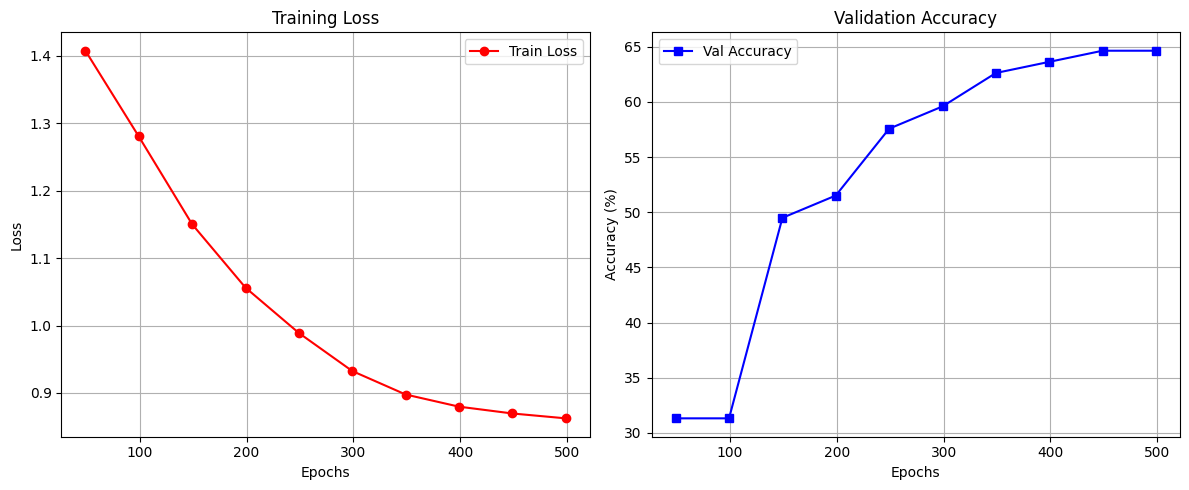

In [75]:
def plot_training_history(history):
    epochs = history['epochs']
    losses = history['train_loss']
    accuracies = history['val_acc']

    # 그래프 크기 설정 (가로 12인치, 세로 5인치)
    plt.figure(figsize=(12, 5))

    # 1. Train Loss 그래프 (왼쪽)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Train Loss', color='red', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # 2. Validation Accuracy 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Val Accuracy', color='blue', marker='s')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout() # 그래프 간 간격 자동 조절
    plt.show()

# 함수 실행
plot_training_history(history)

## 모델 가중치 내보내기

In [76]:
PATH = 'beatsaber_model_weights.pth'

torch.save(model.state_dict(), PATH)

print(f"모델 가중치가 '{PATH}'에 저장되었습니다.")

모델 가중치가 'beatsaber_model_weights.pth'에 저장되었습니다.


## 모델 가중치 불러오기


In [77]:
loaded_model = BeatSaberMLP()

# 2. 저장된 가중치 파일 불러오기
state_dict = torch.load('beatsaber_model_weights.pth', map_location=device)

# 3. 모델에 가중치 입히기
loaded_model.load_state_dict(state_dict)

# 4. 모델을 해당 장치(GPU/CPU)로 이동
loaded_model.to(device)

print("모델 가중치 로드 완료!")
# 단, 추론시에는 추론모드로 바꾸어서 사용할 것. (.eval())

모델 가중치 로드 완료!


## 데이터 저장

In [78]:
import pickle

dataset = {
    'X_train': X_train,
    'Y_train': Y_train,
    'X_valid': X_valid,
    'Y_valid': Y_valid,
    'X_test': X_test,
    'Y_test': Y_test
}

save_path = 'beatsaber_dataset.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(dataset, f)

print(f"모든 데이터셋이 '{save_path}'에 저장되었습니다.")

모든 데이터셋이 'beatsaber_dataset.pkl'에 저장되었습니다.
